In [1]:
# 余分な Warning を非表示にする
import warnings

warnings.filterwarnings('ignore')

# Library の import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib に日本語化
import japanize_matplotlib

# DataFrame 表示用関数
from IPython.display import display

# Originals
from pylab import rcParams
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

# 表示 Option 調整
# NumPy の浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandas での浮動小数点の表示速度
pd.options.display.float_format = '{:.4f}'.format
# DataFrame ですべての項目を表示
pd.set_option('display.max_columns', None)
# Graph の Default Font 指定
plt.rcParams['font.size'] = 14
# 乱数の種
random_seed = 123

#### Original URL
https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
##### ZIP Data
https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip

### Data 項目 Memo
instant: Index
dteday: 日付（yy-mm-dd）
season: 季節（1: 冬, 2: 春, 3: 夏, 4: 秋）
yr: 年(0: 2011,, 1: 2012）
mnth: 月（1 - 12）
hr: 時間(0 - 23）
holiday: 祝日
weekday: 曜日（0-6）
workingday: 勤務日（1: 勤務日, 0: 休日）
weathersit: 天気（1: 晴れから曇り, 2: 霧, 3: 小雨, 4: 大雨）
temp: 気温（正規化済み）
atemp: 体感気温（正規化済）
hum: 湿度（正規化済）
windspeed: 風速（正規化済）
casual: 臨時利用者数
registered: 登録利用者数
cnt: 全体利用者数

## 入力変数
日付、季節、年、月、祝日、曜日、勤務日、天気、気温、体感温度、湿度、風速
## 目的変数
臨時 User 利用数、登録 User 利用数、全体 User 利用数

### Point
- 入力変数の１つに含まれている「日付」。どう扱うかが重要な Point になる。

### 実装方針
目的変数が３つあるので3種類の Model を作ることも可能だが実装が煩雑になる為、目的変数を１つに絞り込むことにする。
数が大きく全体への影響も大きな「登録 User 利用数」に絞り込んで実装を行なう、とす。

### 予測結果の Business 活用案
- 係員の配置数を変更することによる効率化
- 見込み利用数が在庫を上回った場合の予備の自転車の配備

どちらも予測が正確に立てられれば、System 化などは特に考えず人海戦術での対応が可能と思われる。

## Data 読み込みから Data 確認

### Data の Download と解凍

In [2]:
# # Download 元 URL
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
#
# # 公開 Data の Download と解凍
# !wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
# !unzip -o Bike-Sharing-Dataset.zip | tail -n 1

### head command で File の内容を表示

In [3]:
# Data の状態確認
!head -5 day.csv

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562


２列目に日付の項目があることを確認。

### DataFrame への取り込み

In [4]:
# day.csv を DataFrame に取り込み
# 日付を表す列は parse_dates で指定する
df = pd.read_csv('day.csv', parse_dates=[1])

# Data 属性の確認
print(df.dtypes)

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


`parse_dates=[1]` option を指定して２列目を日付型として取り込み、`df.dtypes` で意図した Data 型になっていることを確認。
※ 後で変換する方法もあるが read_csv 関数の呼び出し字に一気に変換をかけた方が Code が simple になる。

### DataFrame の加工

In [5]:
# instant は連番で予測不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化
columns = [
    '日付', '季節', '年', '月', '祝日', '曜日', '勤務日', '天気', '気温', '体感温度', '湿度', '風速', '臨時User利用数', '登録User利用数', '全体User利用数'
]

# 項目名を日本語に置換
df.columns = columns

### DataFrame の内容表示

In [6]:
# 先頭５行の確認
display(df.head())

# 最終５行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時User利用数,登録User利用数,全体User利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時User利用数,登録User利用数,全体User利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


日付項目があるので、`tail`関数で最後の日付も確認。
2011年１月１日から2012年12月31日まで、２年分の Data がある。

目的変数である「登録User利用数」が変動する数値になっていることを確認。
このことから今回の処理 Pattern は **回帰** となる

### Data の Histogram 表示

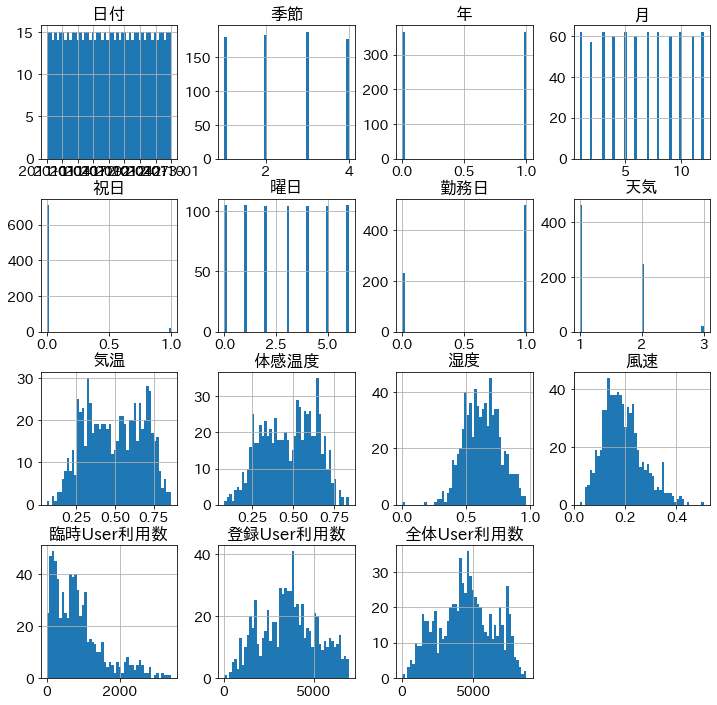

In [7]:
# 度数分布表示

# Graph の size 調整のためのおまじない
rcParams['figure.figsize'] = (12, 12)

# DataFrame の数値項目で Histogram 表示
df.hist(bins=50)
plt.show()

- 体感温度
- 気温
- 湿度
- 風速
について x軸の値の上限が１以下なので、正規化されていることが読み取れる

### 欠損値の調査

In [8]:
# 欠損値の Check
print(df.isnull().sum())

日付           0
季節           0
年            0
月            0
祝日           0
曜日           0
勤務日          0
天気           0
気温           0
体感温度         0
湿度           0
風速           0
臨時User利用数    0
登録User利用数    0
全体User利用数    0
dtype: int64


１つの欠損値もない、きれいな Data である。

### 時系列 Data の Graph 表示
目的変数「登録User利用数」を縦軸にした時系列 Graph を表示してみる。

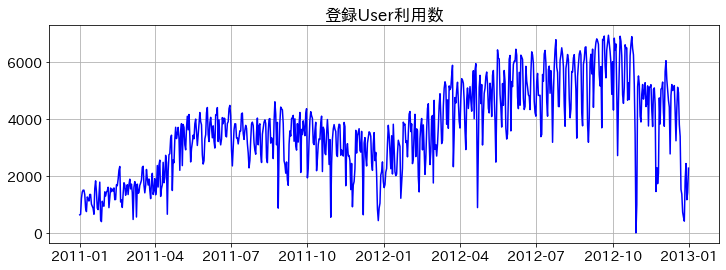

In [9]:
# 時系列 Graph の描画（登録User利用数）
plt.figure(figsize=(12, 4))

# Graph 描画
plt.plot(df['日付'], df['登録User利用数'], c='b')

# 方眼表示など
plt.grid()
plt.title('登録User利用数')

# 画面出力
plt.show()

## Data 前処理と Data 分割
今回の学習 Data は欠損値のないきれいな Data だったので、前処理は一切不要なので Data 分割だけを実施する。
### 目的変数
最初に決めるべきなのは目的変数。
今回は、「登録User利用数」１つに絞ることにする。
### 入力変数
- 日付に関しては落とすことにする。
  日付に関連する入力変数として「年」「月」という情報があるためおおまかなところはこれで対応できるという想定する。
### 訓練 Data と検証 Data への分割
今回の Use case は簡単にいうと「過去の Data から現在・未来を予測する」ことになる。
よく使用されている手法として、Data 系列全体の中から特定の日を選んで、その日より前の Data を訓練 Data とし、その Data で Model を作ってその日以降の予測結果を検証する方法。
今回はこの方針にのっとって、2012年11月１日を区切り日とし、それより前の Data を訓練 Data 、以降の Data を検証 Data とする。
全体で２年分の Data があるので
- 訓練 Data が22ヶ月分
- 検証 Data が２ヶ月分

になる。


### 入力 Data と正解 Data への分割
表形式の Data を
- 入力 Data（入力変数）
- 正解 Data（目的変数）

の左右に分割する。

あわせて同時に学習に不要な項目は削除する。

In [10]:
# x, y への分割
x = df.drop(['日付', '臨時User利用数', '登録User利用数', '全体User利用数'], axis=1)
y = df['登録User利用数'].values

次に、2012年11月１日という日付を Key に、その日より前と後で表形式の Data を訓練 Data と検証 Data へ上下に分割する。

In [11]:
# 分割日 mday の設定
mday = pd.to_datetime('2012-11-1')

# 訓練用 index と検証用 index を作る
train_index = df['日付'] < mday
test_index = df['日付'] >= mday

# 入力 Data の分割
x_train = x[train_index]
x_test = x[test_index]

# y も同様に分割
y_train = y[train_index]
y_test = y[test_index]

# 日付 Data の分割（Graph 表示表）
dates_test = df['日付'][test_index]

1. 境界日の変数 `mday` を定義する。
2. `mday` より前の日付が `True` になる Index 列である `train_index` を作成する。
3. `mday` より後の日付が `True` になる Index 列である `test_index` を作成する。
4. `train_index` と `test_index` を使って
- 入力 Data: `x`
- 正解 Data: `y`

に絞り込んで目的である訓練 Data と検証 Data の分割する。

検証 Data に該当する部分のみ抜き出した変数を `dates_test` も用意しておき、後ほど検証 Data の時系列 Graph を表示するのに利用する。

In [12]:
# 結果確認（Size を確認）
x_train_row_c, x_train_col_c = x_train.shape
print(f'訓練Data', f'行数: {x_train_row_c}', f'列数: {x_train_col_c}')
x_test_row_c, x_test_col_c = x_test.shape
print(f'検証Data', f'行数: {x_test_row_c}', f'列数: {x_test_col_c}')

# 結果確認（境界値を重点的に）
display(x_train.tail())
display(x_test.head())

訓練Data 行数: 670 列数: 11
検証Data 行数: 61 列数: 11


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
665,4,1,10,0,6,0,2,0.5300,0.5151,0.7200,0.2357
666,4,1,10,0,0,0,2,0.4775,0.4678,0.6946,0.3980
667,4,1,10,0,1,1,3,0.4400,0.4394,0.8800,0.3582
668,4,1,10,0,2,1,2,0.3182,0.3099,0.8255,0.2130
669,4,1,10,0,3,1,2,0.3575,0.3611,0.6667,0.1667


,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速
670,4,1,11,0,4,1,2,0.3658,0.3699,0.5817,0.1573
671,4,1,11,0,5,1,1,0.3550,0.3560,0.5221,0.2662
672,4,1,11,0,6,0,2,0.3433,0.3238,0.4913,0.2705
673,4,1,11,0,0,0,1,0.3258,0.3295,0.5329,0.1791
674,4,1,11,0,1,1,1,0.3192,0.3081,0.4942,0.2363


- x_train.tail() の結果が10月分
- x_test.head() の結果が11月分

になっているので、意図した形で Data を上下に分割できていると判断できる。

## Algorithm 選択
XGBRegressor を利用

In [13]:
# Algorithm 選択
algorithm = XGBRegressor(objective='reg:squarederror', random_state=random_seed)

## 学習・予測

In [14]:
# 登録 User 利用数予測 Model の学習と予測

# 学習
algorithm.fit(x_train, y_train)

# 予測
y_pred = algorithm.predict(x_test)

# 予測結果確認
print(y_pred[:5])

[4927.806  4889.2686 3571.434  3637.8308 4719.999 ]


## 評価
- 指標値による方法
- 散布図表示による方法
- 時系列 Graph による方法

の３通りで評価する。

### 指標値による方法
- `score`関数
- R^2値（決定係数）

この２つの値を求める

In [15]:
# 評価（登録 User 利用数）

#score 関数の呼び出し
score = algorithm.score(x_test, y_test)

# R^2値の計算
r2_score = r2_score(y_test, y_pred)

# 結果確認
print(f'score: {score:.4f} r2_score: {r2_score:.4f}')

score: 0.4206 r2_score: 0.4206


一般的に R`2値は、0.5 より大きければ Model として意味がある、とされている。
この基準より
- おしくも意味のある予測ができていない。
- Model として精度が後一歩

と判断する。

### 散布図表示による方法
回帰の Model では、x軸を正解 Data 、y軸を予測結果にして散布図を表示すると理想的には、すべての点が y=x の Graph に乗る。
Model の精度を視覚的に理解する手がかりになる。

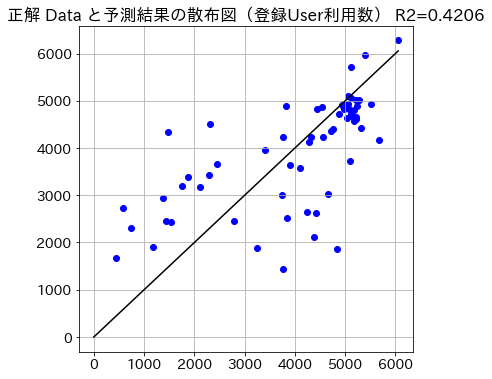

In [16]:
# 正解 Data と予測結果を散布図で比較（登録User利用数）
plt.figure(figsize=(6, 6))
y_max = y_test.max()
plt.plot((0, y_max), (0, y_max), c='k')
plt.scatter(y_test, y_pred, c='b')
plt.title(f'正解 Data と予測結果の散布図（登録User利用数） R2={score:.4f}')
plt.grid()
plt.show()

散布図を見ると、直線にきれいに乗っているとはいえないが２つの軸にある程度の比例関係がありそうと判断できる。

### 時系列 Graph 表示による方法
正解 Data と重ね描きした形で時系列 Graph として表示する方法

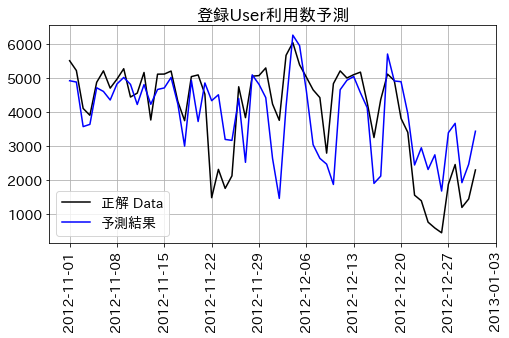

In [17]:
# 時系列 Graph の描画（登録User利用数）
fig, ax = plt.subplots(figsize=(8, 4))

# Graph 描画
ax.plot(dates_test, y_test, label='正解 Data', c='k')
ax.plot(dates_test, y_pred, label='予測結果', c='b')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('登録User利用数予測')

# 画面出力
plt.show()

２つの時系列 Graph の結果を見ると、ぴったり一致しているわけではないが、だいたいの日でまずまずの予想がでていることが読み取れる。

## Tuning
Model を見直し、精度の向上を図る。
入力 Data のうち
- 月
- 季節

に注目し、One-Hot encoding をかけてみる。
※本来なら12月と１月は非常に近いのに、入力 Data の値としては１番離れてしまっており、このことが Model の精度を悪くしている可能性が考えられる。

In [18]:
# 項目を One-Hot encoding するための関数
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df


# 項目「月」「季節」を One-Hot encoding する

x2 = x.copy()
x2 = enc(x2, '月')
x2 = enc(x2, '季節')

# 結果確認
display(x2.head())

,年,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,月_1,月_2,月_3,月_4,月_5,月_6,月_7,月_8,月_9,月_10,月_11,月_12,季節_1,季節_2,季節_3,季節_4
0,0,0,6,0,2,0.3442,0.3636,0.8058,0.1604,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,2,0.3635,0.3537,0.6961,0.2485,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,1,0.1964,0.1894,0.4373,0.2483,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,2,1,1,0.2000,0.2121,0.5904,0.1603,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,3,1,1,0.2270,0.2293,0.4370,0.1869,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
